In [1]:
import torch
from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5
interval = 50

In [3]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size_test, shuffle=True)

In [4]:
train_losses = []
train_counter = []
train_acc = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
def train(model, train_loader, optimizer, epoch):
    model.train()

    for index, (data, label) in enumerate(train_loader):
        correct = 0
        total = 0
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        _, predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        if index % interval == 0:
            train_losses.append(loss.item())
            train_counter.append((index * 64) + ((epoch - 1) * len(train_loader.dataset)))
            train_acc.append(100. * correct/total)


def test(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        for data, label in test_loader:
            test_loss = 0
            correct = 0
            output = model(data)
            test_loss += F.cross_entropy(output, label, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct/len(test_loader.dataset))

In [7]:
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
test(model, test_loader)

for epoch in range(1, n_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

/home/victor/miniconda3/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 2min 36s, sys: 2.88 s, total: 2min 39s
Wall time: 1min 39s


Text(0, 0.5, 'Função de custo')

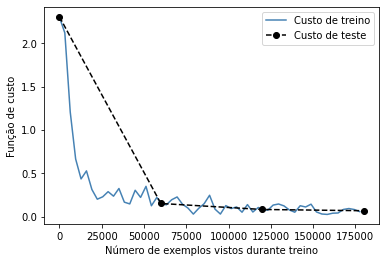

In [9]:
fig = plt.figure()
plt.plot(train_counter, train_losses, linewidth=1.5, color='steelblue')
plt.plot(test_counter, test_losses, '--o', color='black', zorder=10)
plt.legend(['Custo de treino', 'Custo de teste'], loc='upper right')
plt.xlabel('Número de exemplos vistos durante treino')
plt.ylabel('Função de custo')
#plt.savefig('custo_3.svg')

Text(0, 0.5, 'Acurácia')

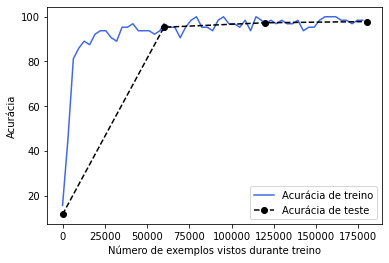

In [10]:
fig = plt.figure()
plt.plot(train_counter, train_acc, linewidth=1.5, color='royalblue')
plt.plot(test_counter, test_acc, '--o', color='black', zorder=10)
plt.legend(['Acurácia de treino', 'Acurácia de teste'], loc='lower right')
plt.xlabel('Número de exemplos vistos durante treino')
plt.ylabel('Acurácia')
#plt.savefig('acc_3.svg')